In [111]:
from random import randint
import sys

import numpy as np
import scipy.optimize as optimize
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, interactive, widgets

plt.style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%xmode plain

def init_simulation(num_nodes, 
                    num_days, 
                    icu_capacities = None, 
                    transport_capacities = None, 
                    ini_path = None, 
                    demand_min = 80, 
                    demand_max = 90):
    if ini_path:
        print("you can also upload an .ini file")
        raise NotImplemented
    else:
        demand = []
        for node in range(num_nodes):
            demand.append(list(np.random.randint(demand_min, demand_max, size = num_days)))

    return icu_capacities, transport_capacities, demand, num_days


def calculate_outgoing(array,day,node):
    return sum(array[day][node])


def calculate_incoming(array,day,node):
    total_outgoing = 0
    for n in range(num_nodes):
        total_outgoing = total_outgoing + array[day][n][node]
    return total_outgoing


def demand_day_node_raw(node_capacity, demand_day, left_day, received_day, demand_previous_days, left_previous_days, received_previous_days):
    return demand_day - left_day + received_day+ min(demand_previous_days-left_previous_days+received_previous_days, node_capacity)


def demand_day_node(movements,day,node):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    total_received_patients = 0
    total_outbound_patients = 0
    accumulated_demand = 0
    for d in range(day+1):
        total_received_patients = total_received_patients + calculate_incoming(movements_res,d,node)
        total_outbound_patients = total_outbound_patients + calculate_outgoing(movements_res,d,node)
    accumulated_demand = sum(demands[node][:day])
    
    demand = max(0, demand_day_node_raw(node_capacities[node],demands[node][day], 
                                        calculate_outgoing(movements_res,day,node), calculate_incoming(movements_res,day,node),
                                        accumulated_demand, total_outbound_patients, total_received_patients                
                ))
    return demand


def calc_total_unnatended(movements):
    total = 0
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    for node in range(num_nodes):
        for day in range(num_days):
            unnatended_not_attended = max(0, demand_day_node(movements,day,node) - node_capacities[node])
            unnant_because_transp = penalization_transport*movements_res[day].sum()
            total = total + unnatended_not_attended + unnant_because_transp
    return total


def outgoing_list(movements):
    movements_res = np.reshape(movements,(num_days,num_nodes,num_nodes))
    outgoing_list = list()
    for day in range(num_days):
        for node in range(num_nodes):
            outgoing_list.append(calculate_outgoing(movements_res,day,node))
    return outgoing_list

def generate_bounds():
    outgoing_list = list()
    for day in range(num_days):
        for outgoing_node in range(num_nodes):
            for incoming_node in range(num_nodes):
                outgoing_list.append((0,transport_capacities[outgoing_node]))
    return outgoing_list

def f_cons(node_id, day):
    return lambda x: transport_capacities[node_id] - calculate_outgoing(np.reshape(x,(num_days,num_nodes,num_nodes)),day ,node_id)


def split_n(num, num_nodes):
    #TODO this function is not truly random
    pieces = []
    for idx in range(num_nodes-1):
        pieces.append(randint(1,num-sum(pieces)-num_nodes+idx))

    pieces.append(num-sum(pieces))
    return pieces

def return_solution_info(movements,icu_capacities,demands):
    occupancy = []
    unattended = []
    for node in range(num_nodes):
        occupancy_list_temp = []
        unattended_list_temp = []
        for day in range(num_days):
            occupancy_temp = demand_day_node(movements,day,node)
            unattended_temp = max(0, occupancy_temp - icu_capacities[node])
            occupancy_list_temp.append(occupancy_temp)
            unattended_list_temp.append(unattended_temp)
        occupancy.append(occupancy_list_temp)
        unattended.append(unattended_list_temp)
    return occupancy, unattended


def random_init(knockdown_days = False, movement_intensity = 1, random_intensity = False, prior_matrix = np.array([])): 
    random_movement = prior_matrix.copy() if prior_matrix.any() else no_movement.copy()
    #if knockdown days is active, behave like a dropdown NN layer and drop half of the days movements
    active_days = np.random.choice([1,0], size=num_days) if knockdown_days else [1]*num_days
    for day in range(num_days):
        if active_days[day]:
            for node_x in range(num_nodes):
                movement_intensity = np.random.uniform() if random_intensity else movement_intensity
                #splits a number in a list of numbers pseudo randomly
                split_nodes = split_n(max(num_nodes+1, 
                                          np.ceil(transport_capacities[node_x]*movement_intensity)), 
                                      num_nodes)
                for node_y in range(num_nodes):
                    if node_x != node_y: 
                        if np.random.choice([0,1]): #allow numbers to decrease too
                            random_movement[day, node_x, node_y] += split_nodes[node_y]
                        else: 
                            random_movement[day, node_x, node_y] -= split_nodes[node_y]
                            random_movement[day, node_x, node_y] = max(0, random_movement[day, node_x, node_y])
                    
    return random_movement

Exception reporting mode: Plain


# Feel free to explore the controls, execute the cell again to restore defaults for an interesting simulation

In [101]:
def read_hospitals(data="uk_hospitals.csv", 
                   latitude_start=54, 
                   latitude_end=56, 
                   longitude_start=-2.5, 
                   longitude_end=-0.5):
    pd.set_option('display.max_rows', None)
    try:
        df = pd.read_csv(data)
        df = df.query(f"{latitude_start} < Latitude < {latitude_end} & {longitude_start} < Longitude < {longitude_end}")
        df = df[["OrgName", "Latitude", "Longitude", "Genera_Acute_beds_open_night", "Total_ICU_beds"]]
        london_region_hospitals = df.copy()
        display(df)
        return df
    except FileNotFoundError:
        print("Please input the file (example: uk_hospitals.csv)")
        
w = interactive(read_hospitals)
w

interactive(children=(Text(value='uk_hospitals.csv', description='data'), IntSlider(value=54, description='lat…

In [107]:
london_region_hospitals = w.result
num_nodes = london_region_hospitals.shape[0]

In [117]:
def config_simulation(transport_capacity=30, demand_min=5, demand_max=70, num_days=4):
    london_region_hospitals["transport_capacity"] = 30
    print(f"""Randomly generated
    {num_days} days, {num_nodes} hospitals
    ICU capacities of hospitals: {node_capacities}
    Daily transport capacities: {transport_capacities}, 
    Daily simulated demand (from uniform distrution): 
    {demands}""")
    return init_simulation(num_nodes, num_days, 
                          icu_capacities=london_region_hospitals["Total_ICU_beds"].values,
                          transport_capacities=london_region_hospitals["transport_capacity"].values, 
                          demand_min = 5, demand_max = 70)
    
w2 = interactive(config_simulation)
w2

interactive(children=(IntSlider(value=30, description='transport_capacity', max=90, min=-30), IntSlider(value=…

In [114]:
node_capacities, transport_capacities, demands, num_days = w2.result

In [118]:
#define constraints
cons = []
for node in range(num_nodes):
    for day in range(num_days):
        cons.append({'type': 'ineq', 'fun': f_cons(node,day)})

        
#no movement matrix, the base for generating random ones and one of the ones to test as init matrix 
no_movement = np.array([[[0]*num_nodes]*num_nodes]*num_days)

### The main loop that generates random init matrices

In [ ]:
%%time

penalization_transport = 0
#parameters to minimize
min_unnatended = sys.maxsize
best_result = None
result_matrix = None
#iterate through low to high intensity movement simulation
steps = []
knockdown = True
win_init_matrix = no_movement.copy()
iterations = 100
movement_intensity = 0.5
miss = 0
candidates = []
bounds_movement = generate_bounds()
for i in range(iterations):
    print(f"i:{i} intensity: {movement_intensity:.2f} knockdown: {knockdown} ", end="")

    if movement_intensity < 0.1 or miss >= 25:
        miss = 0
        #if there are candidates, try those first with reasonable parameters
        if candidates:
            print(f"using candidate from {len(candidates)} candidates list")
            movement = candidates.pop() 
            movement_intensity = 0.5
            knockdown = True
            miss = 0
        else:
            #otherwise go all-in
            print("going into full evolution", end="")
            movement = random_init(False, 1, prior_matrix=win_init_matrix)
    else:
        movement = random_init(knockdown, movement_intensity, prior_matrix=win_init_matrix)
        
        result = optimize.minimize(calc_total_unnatended, 
                                   movement, 
                                   method='SLSQP', 
                                   constraints=cons, 
                                   bounds=bounds_movement)

        current_unnatended = calc_total_unnatended(np.rint(result.x))
        print(f"Result:{current_unnatended:.0f}", end="")
        steps.append([movement_intensity, knockdown, current_unnatended])
        if min_unnatended == current_unnatended:
            print(" <--saving!", end="")        
            candidates.append(movement)
        elif min_unnatended > current_unnatended:
            knockdown = True
            miss = 0
            movement_intensity *= 0.9
            movement_intensity = min(0.5, movement_intensity)
            candidates = []
            print(" <--best!", end="")
            min_unnatended = int(current_unnatended)
            best_result = result
            result_matrix = np.reshape(np.rint(result.x),(num_days,num_nodes,num_nodes))
            win_init_matrix = movement
        else:
            movement_intensity = min(1, movement_intensity*1.05)
            miss += 1

    print("")
        
print("\nDone")

i:0 intensity: 0.50 knockdown: True Result:1030 <--best!
i:1 intensity: 0.45 knockdown: True 

### These are the unnatended that we get with inaction

In [59]:
calc_total_unnatended(no_movement)

972

### This is the best result found

In [60]:
min_unnatended

840

### This the movement matrix

In [61]:
result_matrix

array([[[ 0.,  3.,  1.,  1.,  2.,  2.,  1.,  5.],
        [ 1.,  0.,  1.,  3.,  2.,  1.,  4.,  1.],
        [ 2.,  2.,  0.,  3.,  4.,  3.,  3.,  3.],
        [ 5.,  3.,  2.,  0.,  2.,  1.,  3.,  1.],
        [ 1.,  7.,  2.,  1.,  0.,  2.,  1.,  1.],
        [ 1.,  1.,  2.,  1.,  5.,  0.,  2.,  6.],
        [ 2.,  1.,  2.,  1.,  3.,  1.,  0.,  2.],
        [ 6.,  1.,  1.,  1.,  1.,  2.,  0.,  0.]],

       [[ 0.,  2.,  0.,  4.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.],
        [18.,  5.,  0.,  5.,  1.,  0.,  0.,  0.],
        [ 8.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
        [16.,  4.,  0.,  3.,  0.,  0.,  0.,  0.],
        [17.,  4.,  0.,  6.,  2.,  0.,  0.,  0.],
        [10.,  9.,  0.,  5.,  3.,  1.,  0.,  1.],
        [ 5., 13.,  0.,  6.,  3.,  2.,  0.,  0.]],

       [[ 0., 19.,  0.,  2.,  1.,  2.,  3.,  2.],
        [ 7.,  0.,  0.,  4.,  1.,  1.,  5.,  6.],
        [ 3.,  0.,  0.,  1.,  2.,  0.,  3.,  0.],
        [ 0.,  0.,  1.,  0.,  2.,  3.,  3.,  4

### These are the stats day by day

In [62]:
occupancy, unattended = return_solution_info(result_matrix,node_capacities,demands)

In [63]:
occupancy

[[51.0, 179.0, 113.0, 120.0],
 [36.0, 91.0, 36.0, 99.0],
 [0, 15.0, 57.0, 50.0],
 [53.0, 84.0, 42.0, 60.0],
 [17.0, 14.0, 19.0, 19.0],
 [33.0, 32.0, 46.0, 36.0],
 [46.0, 51.0, 65.0, 95.0],
 [31.0, 28.0, 81.0, 48.0]]

In [64]:
unattended

[[5.0, 133.0, 67.0, 74.0],
 [16.0, 71.0, 16.0, 79.0],
 [0, 15.0, 57.0, 50.0],
 [18.0, 49.0, 7.0, 25.0],
 [0, 0, 1.0, 1.0],
 [0, 0, 13.0, 3.0],
 [0, 5.0, 19.0, 49.0],
 [0, 0, 50.0, 17.0]]

In [65]:
df = pd.DataFrame(steps)
df.columns = ["movement_intensity", "knockdown", "result"]

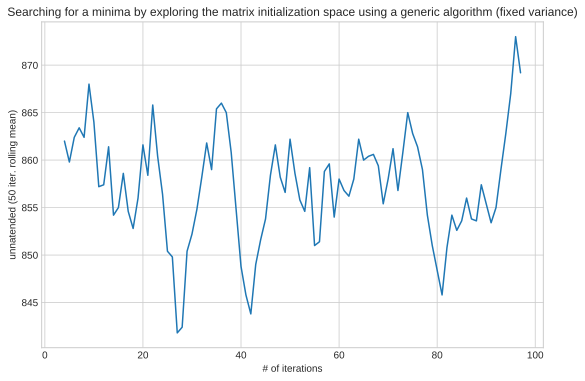

In [70]:
df.result.rolling(5).mean().plot(figsize=(9, 6), title="Searching for a minima by exploring the matrix initialization space using a generic algorithm (fixed variance)")
plt.xlabel("# of iterations")
plt.ylabel("unnatended (50 iter. rolling mean)");

In [67]:
for node in range(num_nodes):
    for day in range(num_days):
        print(f'Node: {node}, Day: {day}, Demand: {demand_day_node(np.rint(result.x),day,node)}')

Node: 0, Day: 0, Demand: 47.0
Node: 0, Day: 1, Demand: 179.0
Node: 0, Day: 2, Demand: 113.0
Node: 0, Day: 3, Demand: 117.0
Node: 1, Day: 0, Demand: 69.0
Node: 1, Day: 1, Demand: 91.0
Node: 1, Day: 2, Demand: 36.0
Node: 1, Day: 3, Demand: 88.0
Node: 2, Day: 0, Demand: 0
Node: 2, Day: 1, Demand: 5.0
Node: 2, Day: 2, Demand: 57.0
Node: 2, Day: 3, Demand: 49.0
Node: 3, Day: 0, Demand: 39.0
Node: 3, Day: 1, Demand: 84.0
Node: 3, Day: 2, Demand: 43.0
Node: 3, Day: 3, Demand: 64.0
Node: 4, Day: 0, Demand: 17.0
Node: 4, Day: 1, Demand: 14.0
Node: 4, Day: 2, Demand: 18.0
Node: 4, Day: 3, Demand: 14.0
Node: 5, Day: 0, Demand: 33.0
Node: 5, Day: 1, Demand: 30.0
Node: 5, Day: 2, Demand: 47.0
Node: 5, Day: 3, Demand: 40.0
Node: 6, Day: 0, Demand: 42.0
Node: 6, Day: 1, Demand: 49.0
Node: 6, Day: 2, Demand: 65.0
Node: 6, Day: 3, Demand: 98.0
Node: 7, Day: 0, Demand: 33.0
Node: 7, Day: 1, Demand: 33.0
Node: 7, Day: 2, Demand: 80.0
Node: 7, Day: 3, Demand: 54.0
